In [1]:
X_DIM = 256
Y_DIM = 256
UNPROCESSED_DIRECTORY = "CNN_synth_testset"
PROCESSED_DIRECTORY = "processed_images"
CROP = False
import os
import numpy as np
from PIL import Image as im_lib
from PIL import ImageFilter
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Layer, Input, concatenate, MaxPooling2D, Conv2D, Dense, Dropout, Flatten
from keras import models, Model
from keras import layers
from keras.utils import Sequence
from keras.utils import plot_model
from keras.metrics import Metric
import keras.backend as backend
import tensorflow as tf
from math import ceil
from sklearn.model_selection import train_test_split
import time

In [2]:
def obtain_image_paths(unprocessed_directory = UNPROCESSED_DIRECTORY):
    data_directory = os.listdir("./"+unprocessed_directory)
    list_of_image_paths = []
    for dirpath, dirname, filename in os.walk("./"+unprocessed_directory):
        if not dirname:
            for dirpath2, dirname2, filename2 in os.walk(dirpath):
                for filedir in filename2:
                    list_of_image_paths.append(dirpath+"/"+filedir)
    return list_of_image_paths

In [3]:
#Create constants and import libraries
def categorical_output(image_path):
    keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan","stylegan2", "stylegan",
           "whichfaceisreal"]
    category = [0] * (len(keywords) + 1)
    for kwd_index in range(len(keywords)):
        kwd = keywords[kwd_index]
        if kwd in image_path:
            category[kwd_index] = 1
            return category
    category[-1] = 1
    return category
class ImageBatchSequence(Sequence):
    def __init__(self, x_set, batch_size, filter_functions=None, x_dim = X_DIM, y_dim = Y_DIM, 
                 output_function = None):
        self.x = x_set
        if output_function is None:
            y_set = [(1 if "fake" in image_path else 0) for image_path in x_set] #This makes the output to be 1 (AI-generated) if FAKE is in pathname.
            #                                                  # Otherwise, it makes the output 0 (not AI-generated)
        else:
            y_set = [output_function(image_path) for image_path in x_set]
        self.y = y_set
        self.batch_size = batch_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.filter_functions = filter_functions #each filter function should return a normalized array
    def __len__(self):
        return ceil(len(self.x)/self.batch_size)
    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low+self.batch_size, len(self.x))
        batch_x = self.x[low : high]
        batch_y = self.y[low : high]
        if self.filter_functions is None:
            image_x_batches = [np.array([normalize_image(image_path) for image_path in batch_x])]
        else:
            image_x_batches = [np.array([f(im_lib.open(image_path)) for image_path in batch_x]) for f in self.filter_functions]
        return image_x_batches, [np.array(batch_y)]

In [4]:
X = obtain_image_paths(PROCESSED_DIRECTORY)
y = [categorical_output(x) for x in X]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2, stratify = y)

In [6]:
keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan", "stylegan",
           "stylegan2","whichfaceisreal"]
for kwd in keywords:
    print(kwd+":"+str(y_train.count(categorical_output(kwd))))
print("real : "+str(y_train.count(categorical_output("fuck"))))
print(";;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;")
for kwd in keywords:
    print(kwd+":"+str(y_test.count(categorical_output(kwd))))
print("real : "+str(y_test.count(categorical_output("fuck"))))

biggan:1600
crn:5106
cyclegan:1057
deepfake:4324
gaugan:4000
imle:5105
progan:3200
san:174
seeingdark:144
stargan:1599
stylegan:4793
stylegan2:6390
whichfaceisreal:800
real : 33960
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
biggan:400
crn:1276
cyclegan:264
deepfake:1081
gaugan:1000
imle:1277
progan:800
san:43
seeingdark:36
stargan:400
stylegan:1198
stylegan2:1598
whichfaceisreal:200
real : 8490


In [7]:
X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 254, 254, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 254, 254, 32)         896       ['input_2[0][0]']             
                                                                                              

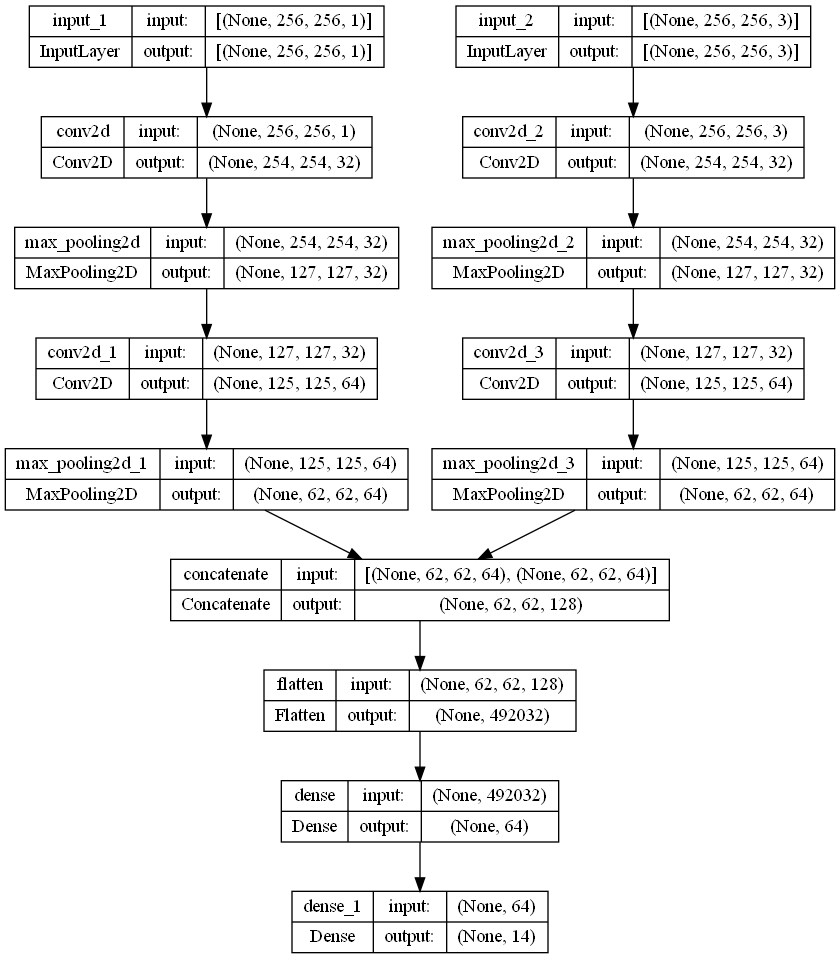

In [8]:
#discrete cosine transform on the grayscale image
gdct_input = Input(shape=(256,256,1))
gdct_1 = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(gdct_input)
gdct_2 = MaxPooling2D(pool_size=(2,2),strides=2)(gdct_1)
gdct_3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(gdct_2)
gdct_4 = MaxPooling2D(pool_size=(2,2),strides=2)(gdct_3)

#highpass filter
highpass_input = Input(shape=(256,256,3))
highpass_1 = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(highpass_input)
highpass_2 = MaxPooling2D(pool_size=(2,2),strides=2)(highpass_1)
highpass_3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(highpass_2)
highpass_4 = MaxPooling2D(pool_size=(2,2),strides=2)(highpass_3)


merged_1 = concatenate([gdct_4, highpass_4])
merged_2 = Flatten()(merged_1)
merged_3 = Dense(units=64, activation='relu')(merged_2)
multiclass= Dense(units=14, activation = 'softmax')(merged_3)

model = Model(inputs = [gdct_input,highpass_input], outputs = multiclass)


model.summary()
plot_model(model, show_shapes=True)

In [9]:
class MulticlassPrecisionMetric(Metric):
    def __init__(self, name = "mp", category_tested = 0):
        super(MulticlassPrecisionMetric,self).__init__(name = name)
        self.category_tested = category_tested
        self.multi_true_positives = self.add_weight(name = 'tp' + str(self.category_tested), initializer = 'zeros')
        self.multi_tf_positives = self.add_weight(name = 'tfp' + str(self.category_tested), initializer = 'zeros')
        self.mp = self.add_weight(name = 'mp' + str(self.category_tested), initializer = 'zeros')
    def update_state(self, y_true, y_pred, sample_weight = None):
        y_true = tf.argmax(y_true, axis = -1)
        y_pred = tf.argmax(y_pred, axis = -1)
        tp = tf.reduce_sum(\
                         tf.cast(tf.equal(y_true,self.category_tested),tf.float32)\
                         *tf.cast(tf.equal(y_pred,self.category_tested),tf.float32))
        self.multi_true_positives.assign_add(tp)
        self.multi_tf_positives.assign_add(\
                                           tf.reduce_sum(\
                                                       tf.cast(tf.equal(y_pred,self.category_tested),tf.float32)))
        self.mp.assign(self.multi_true_positives/(self.multi_tf_positives+backend.epsilon()))
    def result(self):
        return self.mp
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [10]:
class MulticlassRecallMetric(Metric):
    def __init__(self, name = "mp", category_tested = 0):
        super(MulticlassRecallMetric,self).__init__(name = name)
        self.category_tested = category_tested
        self.multi_true_positives = self.add_weight(name = 'tp' + str(self.category_tested), initializer = 'zeros')
        self.multi_predic = self.add_weight(name = 'tpr' + str(self.category_tested), initializer = 'zeros')
        self.mr = self.add_weight(name = 'mr' + str(self.category_tested), initializer = 'zeros')
    def update_state(self, y_true, y_pred,sample_weight = None):
        y_true = tf.argmax(y_true, axis = -1)
        y_pred = tf.argmax(y_pred, axis = -1)
        tp = tf.reduce_sum(\
                         tf.cast(tf.equal(y_true,self.category_tested),tf.float32)\
                         *tf.cast(tf.equal(y_pred,self.category_tested),tf.float32))
        self.multi_true_positives.assign_add(tp)
        self.multi_predic.assign_add(\
                                           tf.reduce_sum(\
                                                       tf.cast(tf.equal(y_true,self.category_tested),tf.float32)))
        self.mr.assign(self.multi_true_positives/(self.multi_predic+backend.epsilon()))
    def result(self):
        return self.mr
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [11]:
keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan","stylegan2",
            "stylegan", "whichfaceisreal"]
METRICS = []
for kwd_index in range(len(keywords)):
    precision_metric = MulticlassPrecisionMetric(name = "precision_"+keywords[kwd_index], 
                                                 category_tested = kwd_index)
    recall_metric = MulticlassRecallMetric(name = "recall_"+keywords[kwd_index], 
                                                 category_tested = kwd_index)
    METRICS.append(precision_metric)
    METRICS.append(recall_metric)
precision_metric = MulticlassPrecisionMetric(name = "precision_real", category_tested = len(keywords))
recall_metric = MulticlassRecallMetric(name = "recall_real", category_tested = len(keywords))
METRICS.append(precision_metric)
METRICS.append(recall_metric)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = [METRICS])

In [12]:
def normalize_image(image,normalizing_factor=255):
    if image.mode == 'RGB':
        return np.asarray(image).reshape(image.size[0],image.size[1],3)/normalizing_factor
    if image.mode == 'L':
        return np.assarray(image)/normalizing_factor

def HPF_filter(image):
    return normalize_image(im_lib.fromarray(np.asarray(image)-np.asarray(image.filter(ImageFilter.GaussianBlur))))

#convolutional highpass filter for each color channel
def highpassrgb(image):
    red, green, blue = image.split()
    return normalize_image(im_lib.merge(mode='RGB',bands=(red.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)), green.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)), blue.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)))))

#grayscale discrete cosine transform
def gdct(image):
    a = np.array(image.convert('L'))
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

#log-scaled and normalized gdct
def normalized_gdct(image,normalizing_factor=20):
    #normalizing factor was chosen so both inputs would have similar scaling 
    array = gdct(image)
    sgn = np.sign(array)
    logscale = sgn*np.log(abs(array)+0.000000001) #symmetric log scale, shifted slightly to be defined at 0
    return (logscale.astype(np.float32)/normalizing_factor)
    

In [ ]:
train_sequence = ImageBatchSequence(X_train_train, batch_size = 32, filter_functions= [normalized_gdct, highpassrgb], 
                                    output_function = categorical_output)
validation_sequence = ImageBatchSequence(X_val, batch_size = 32, filter_functions= [normalized_gdct, highpassrgb],
                                    output_function = categorical_output)

In [ ]:
epoch_count = 20
history = model.fit(train_sequence, epochs = epoch_count, validation_data = validation_sequence)
history_dict = history.history
print(history_dict.keys())
model.save("dual_channel_model")
model.save_weights("dual_channel_model_best_val_real_precision_weights")
np.save("my_history.npy",history.history)
#to load training history, use history_dict=np.load('my_history.npy',allow_pickle='TRUE').item()

In [ ]:
import matplotlib.pyplot as plt
for kwd in keywords:
    training_kwd_precision = "precision_" + kwd
    training_kwd_recall = "recall_" + kwd
    validation_kwd_precision = "val_precision_" + kwd
    validation_kwd_recall = "val_recall_" + kwd
    plt.figure(figsize = (8,6))
    plt.plot(range(1,epoch_count + 1), history_dict[training_kwd_precision], label = "Training " +kwd+ " Precision")
    plt.plot(range(1,epoch_count + 1), history_dict[training_kwd_recall], label = "Training " +kwd+ " Recall")
    plt.plot(range(1,epoch_count + 1), history_dict[validation_kwd_precision], label = "Validation " +kwd+ " Precision")
    plt.plot(range(1,epoch_count + 1), history_dict[validation_kwd_recall], label = "Validation " +kwd+ " Recall")
    plt.legend(fontsize = 10)
    plt.savefig(kwd+'.pdf', bbox_inches='tight')
    plt.show()

plt.figure(figsize = (8,6))
plt.plot(range(1,epoch_count + 1), history_dict["precision_real"], label = "Training Real Precision")
plt.plot(range(1,epoch_count + 1), history_dict["recall_real"], label = "Training Real Recall")
plt.plot(range(1,epoch_count + 1), history_dict["val_precision_real"], label = "Validation Real Precision")
plt.plot(range(1,epoch_count + 1), history_dict["val_recall_real"], label = "Validation Real Recall")
plt.legend(fontsize = 10)
plt.savefig(kwd+'.pdf', bbox_inches='tight')
plt.show()